In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter

folder = "../trictrac_database"

In [17]:
avis_clean = pd.read_csv(f'{folder}/avis_clean.csv', header=None, names=["Game id", "User id", "Game name UI", "Username", "Datetime", "Rating", "Comment title", "Comment body"]).drop_duplicates()
users = pd.read_csv(f'{folder}/users.csv', header=None, names = ["Username", "User id"]).drop_duplicates()
avis_clean["Datetime"] = pd.to_datetime(avis_clean["Datetime"])
jeux_clean = pd.read_csv("../database_cleaned/jeux_clean.csv")

In [18]:
def plot_hist_count(data, ax, x_labels_vis = False, y_label=None, title=None, rotation=90, sorted=False):
    """Plot histogram (bars). Data : doit être formé de 2 colonnes : index et values (e.g. à l'aide de group by)"""
    
    ax.clear()
    
    if sorted:
        data.sort_index(inplace=True)

    x_coords = np.arange(stop = data.shape[0])

    bars = ax.bar(x_coords, height=data.values.flatten())

    nan_check = data.index.isna()

    if nan_check.any(): # change NaN bar color to red
            x_labels = data.index
            bars[np.where(nan_check)[0][0]].set_color('r')
            
    if x_labels_vis:
        ax.tick_params(axis='x', labelrotation=rotation)
        ax.set_xticks(x_coords)  # Set the tick positions
        ax.set_xticklabels(data.index)
        ax.xaxis.set_major_locator(plt.FixedLocator(x_coords))
    else:
        ax.xaxis.set_visible(False)

    if title:
        ax.set_title(title)

    if y_label:
        ax.set_ylabel(y_label)
    return ax

In [19]:
fig = plt.figure(figsize=(10, 5))

<Figure size 1000x500 with 0 Axes>

In [20]:
# # Verification to safely plot Username instead of User id
avis_clean[["User id", "Username"]].nunique()


User id     11201
Username    11201
dtype: int64

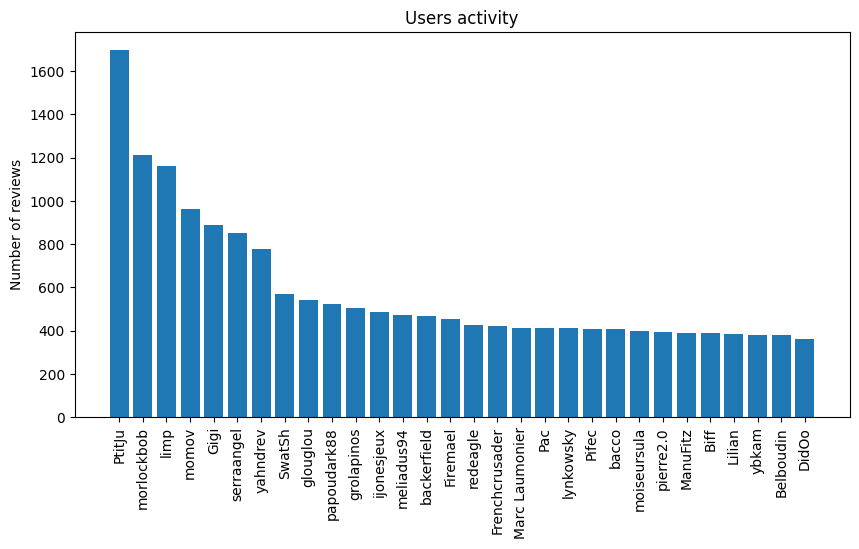

In [21]:
# Plot users by number of theirs reviews
fig.clear()
fig.set_figheight(5)

users_nb_rev = avis_clean[["Username", "Game id"]].groupby("Username", as_index=True).count()
ax = plot_hist_count(users_nb_rev.sort_values("Game id", ascending=False).head(30),
                     fig.add_subplot(111), x_labels_vis=True, y_label="Number of reviews", title="Users activity")
fig

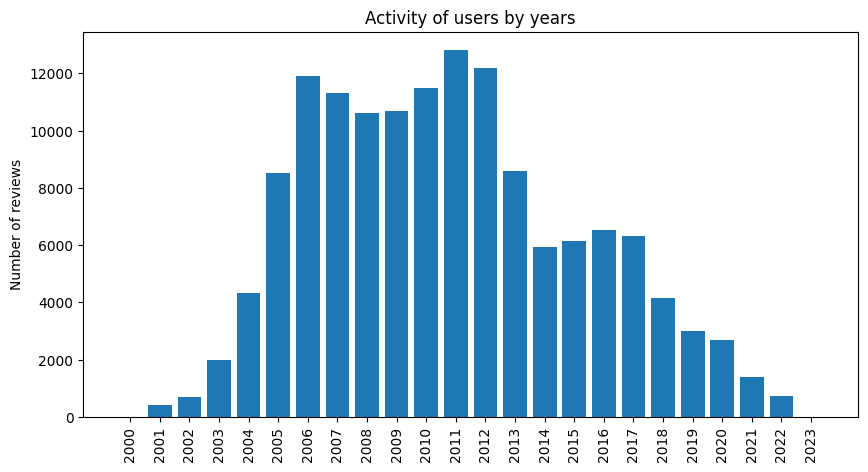

In [22]:
# Plot activity by years
dt_valid_years = avis_clean[~avis_clean["Datetime"].isna()]
dt_valid_years["Year"] = dt_valid_years["Datetime"].dt.year
dt_valid_years["Month"] = dt_valid_years["Datetime"].dt.month
years_counter = dt_valid_years[["User id", "Year"]].groupby("Year", as_index=True).count()

fig.clear()
plot_hist_count(years_counter, fig.add_subplot(111), x_labels_vis=True, y_label="Number of reviews", title="Activity of users by years")
fig

In [23]:
# Plot activity by months for all years. Years are ranged from the most to the least active ones  
def plot_months(ym_counter, fig):
    years = list(ym_counter.keys())

    for i in range(0, len(ym_counter)):  
        ax = fig.add_subplot(len(ym_counter) // 4, 4, i+1)  # grid 
        plot_hist_count(ym_counter[years[i]], ax, True, rotation=0, sorted=True)
        ax.set_title(f"{years[i]}")

    fig.tight_layout()
    
ym_counter = dict()
fig.set_figheight(7)

for year in years_counter.sort_values(by="User id", ascending=False).index:
    ym_counter[year] = dt_valid_years[dt_valid_years["Year"] == year][["User id", "Month"]].groupby("Month", as_index=True).count()

    #Counter(dt_valid.loc[dt_valid["Datetime"].dt.year == year, "Datetime"].dt.month)
# fig.clear()
# plot_months(ym_counter, fig)
# fig


In [24]:
def plot_hist_ratings(data, ax, x_label=None, y_label=None, title=None, min_x=0., max_x=10., interval=0.5, bins_factor=25):
    ax.hist(data, range=[min_x, max_x], bins=int(max_x - min_x) * bins_factor)
    ax.set_xticks(np.arange(min_x, max_x+interval, interval))

    if x_label:
        ax.set_xlabel(x_label)
    if y_label:
        ax.set_ylabel(y_label)
    if title:
        ax.set_title(title)

def scatter_ratings(x, y, ax, x_label, y_label, point_label, title=None):
    ax.scatter(x, y, s=2, label=point_label)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.legend()
    if title:
        ax.set_title(title)


In [42]:
# Distribution of average ratings
all_ratings = avis_clean[["Game id", "Rating"]][~avis_clean["Rating"].isna()].groupby(by="Game id", as_index=True)
ratings_means = all_ratings.mean()
ratings_counts = all_ratings.count()

ratings_stats = pd.concat([ratings_means, ratings_counts], axis=1)
ratings_stats.columns = ["Mean", "Number of reviews"]
ratings_stats

,Mean,Number of reviews
Game id,,
0,2.000000,1
1,9.333333,3
2,6.333333,6
3,8.000000,2
4,6.390909,11
...,...,...
10544,10.000000,2
10545,3.000000,2
10546,7.037143,140


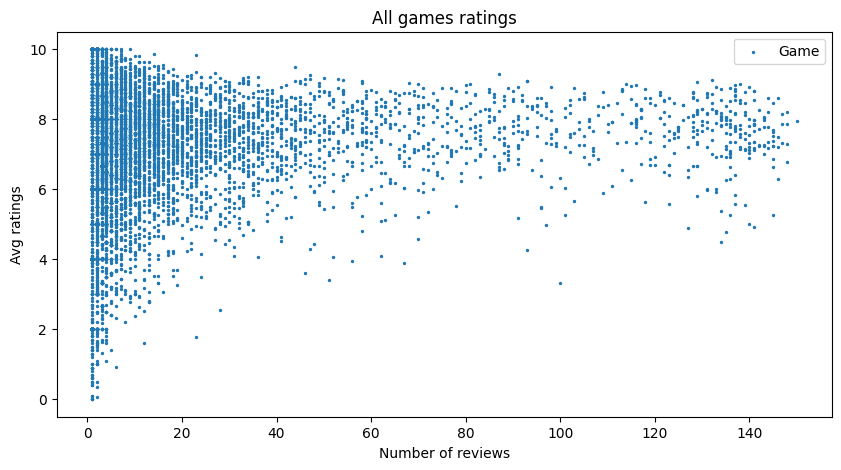

In [26]:
fig.clear()
fig.set_figheight(5)
scatter_ratings(ratings_stats["Number of reviews"], ratings_stats["Mean"], fig.add_subplot(111),
                x_label="Number of reviews", y_label="Avg ratings", point_label="Game", title="All games ratings")
fig

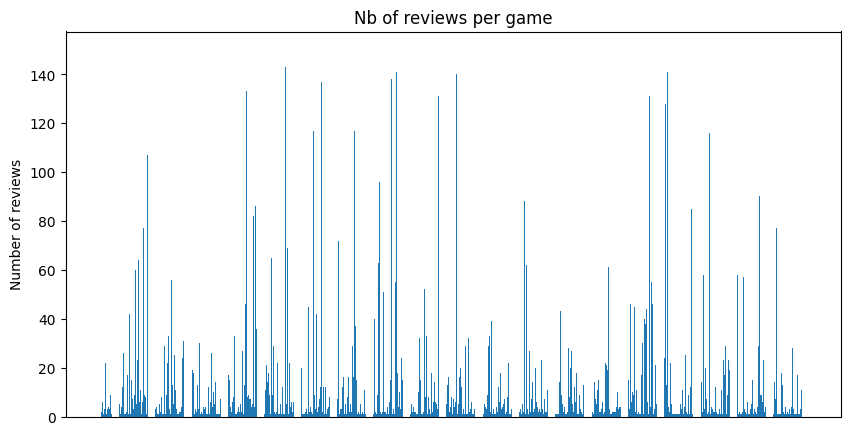

In [44]:
fig.clear()
fig.set_figheight(5)
plot_hist_count(ratings_stats["Number of reviews"], ax=fig.add_subplot(111),
                x_labels_vis=False, y_label="Number of reviews",title="Nb of reviews per game")
fig

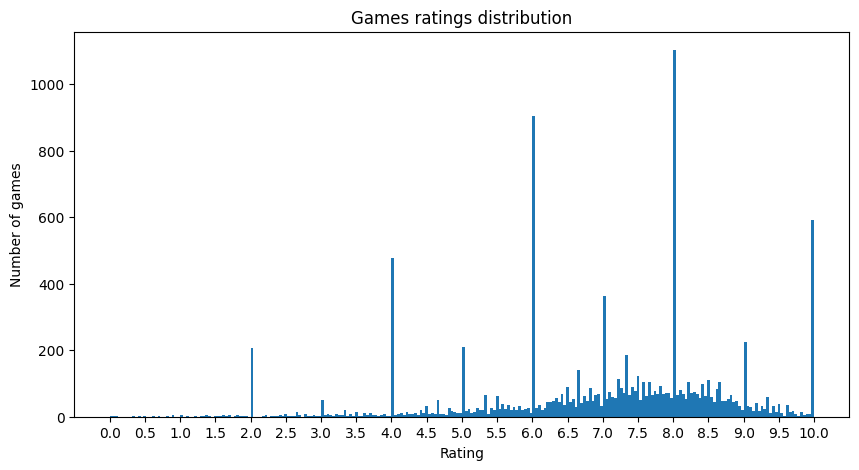

In [27]:
fig.set_figheight(5)

fig.clear()
plot_hist_ratings(ratings_means["Rating"], fig.add_subplot(111), "Rating", "Number of games", title="Games ratings distribution")
fig

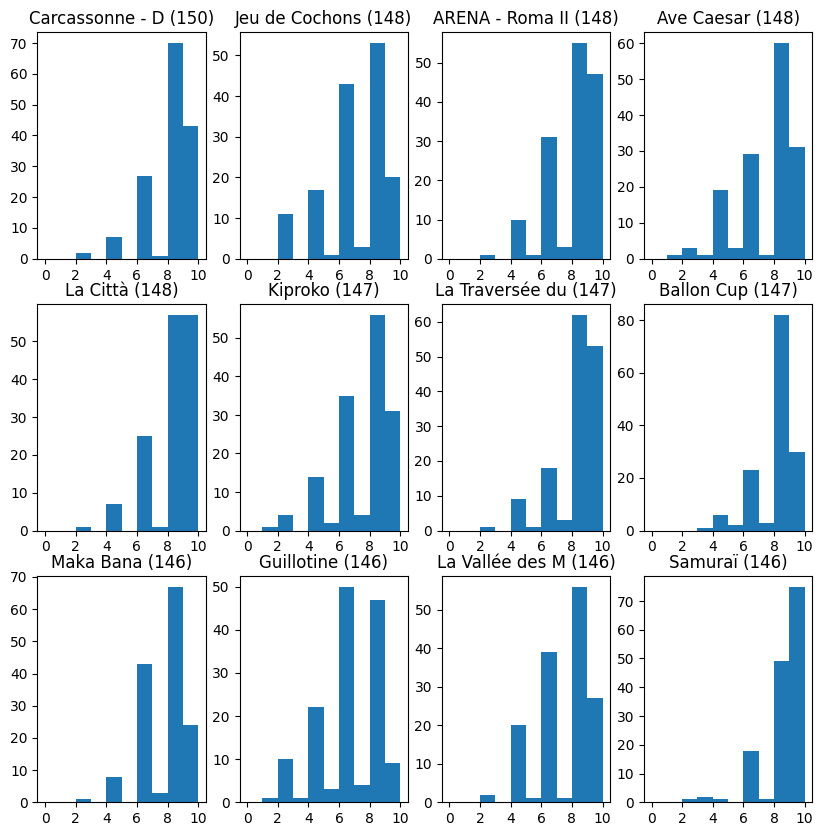

In [28]:
# 1. Take top N (= 12) most popular games (nb_reviews > 30), draw the distribution of their ratings
ids_review_counter = Counter(avis_clean["Game id"]).most_common(12)
ratings_valid = avis_clean[["Game name UI", "Rating"]][~avis_clean["Rating"].isna()]

# Replace game IDs by UI names
names_review_counter = dict()
for id, count in ids_review_counter:
    gamename = avis_clean["Game name UI"][avis_clean["Game id"] == id].iloc[0]

    if gamename in names_review_counter:
        print(f"Attention! {gamename} has multiple IDs")

    names_review_counter[gamename] = count

names_review_counter = list(names_review_counter.items())

fig.set_figheight(10)
fig.clear()

for i in range(12):
    ax = fig.add_subplot(3, 4, i+1)
    gamename, count = names_review_counter[i]
    #print(ratings_valid["Rating"][ratings_valid["Game name UI"] == gamename])
    plot_hist_ratings(ratings_valid["Rating"][ratings_valid["Game name UI"] == gamename], ax=ax, title=f"{gamename[:15]} ({count})", interval=2, bins_factor=1)

fig


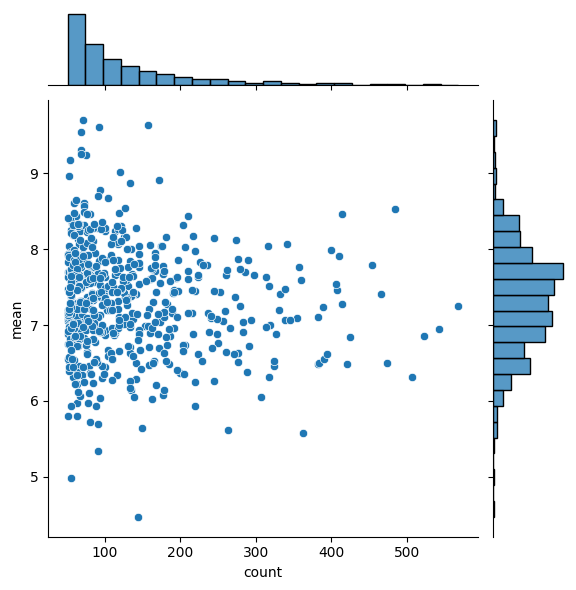

In [39]:
# Users ratings analysis
avis_clean.head()

users_ratings = avis_clean[["Username", "Rating"]].groupby("Username").agg(count=("Rating","count"), mean=("Rating", "mean")).reset_index()

sns.jointplot(users_ratings[(users_ratings["count"] < 600) & (users_ratings["count"] > 50)], x="count", y="mean")
#fig.set_figheight(5)
# fig.clear()
# scatter_ratings(users_ratings["count"], users_ratings["mean"], fig.add_subplot(111),
#                 x_label="Number of reviews per user", y_label="Avg ratings per user",
#                 point_label="User", title="All users ratings")


In [20]:
def violin_plot(data, ax, data_labels, y_label, title, rotation=90):
    ax.violinplot(data, showextrema=True, showmeans=True)

    labels_coords = np.arange(start=1, stop = data.index.size+1)
    
    if data_labels is not None:
        ax.tick_params(axis='x', labelrotation=rotation)
        ax.set_xticks(np.arange(start=1, stop=data.index.size+1))  # Set the tick positions
        ax.set_xticklabels(data_labels)
        ax.xaxis.set_major_locator(plt.FixedLocator(labels_coords))

        
    ax.set_ylabel(y_label)
    ax.set_title(title)

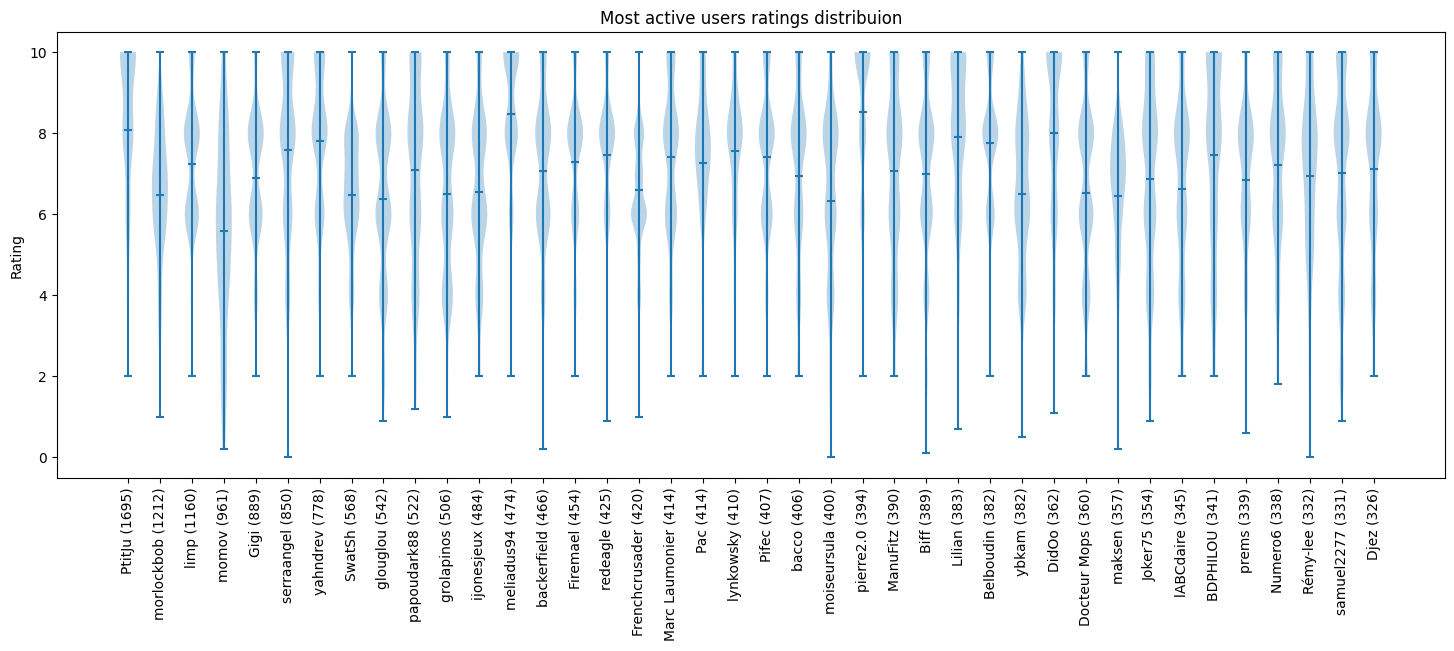

In [21]:
# Choose most active users (top X number of reviews based)

top_users = users_ratings.nlargest(n=40, columns="count")
top_users_merged = top_users.merge(avis_clean[["Username", "Rating"]], on="Username")
violinplot_data = top_users_merged[["Username", "Rating"]].groupby(by="Username")["Rating"].apply(np.array)
fig.set_figwidth(15)
fig.clear()
violin_plot(violinplot_data, ax=fig.add_subplot(111),
            data_labels=np.vectorize(lambda user, count: f"{user} ({count})")(top_users["Username"], top_users["count"]),
            y_label="Rating", title="Most active users ratings distribuion", rotation=90)
fig

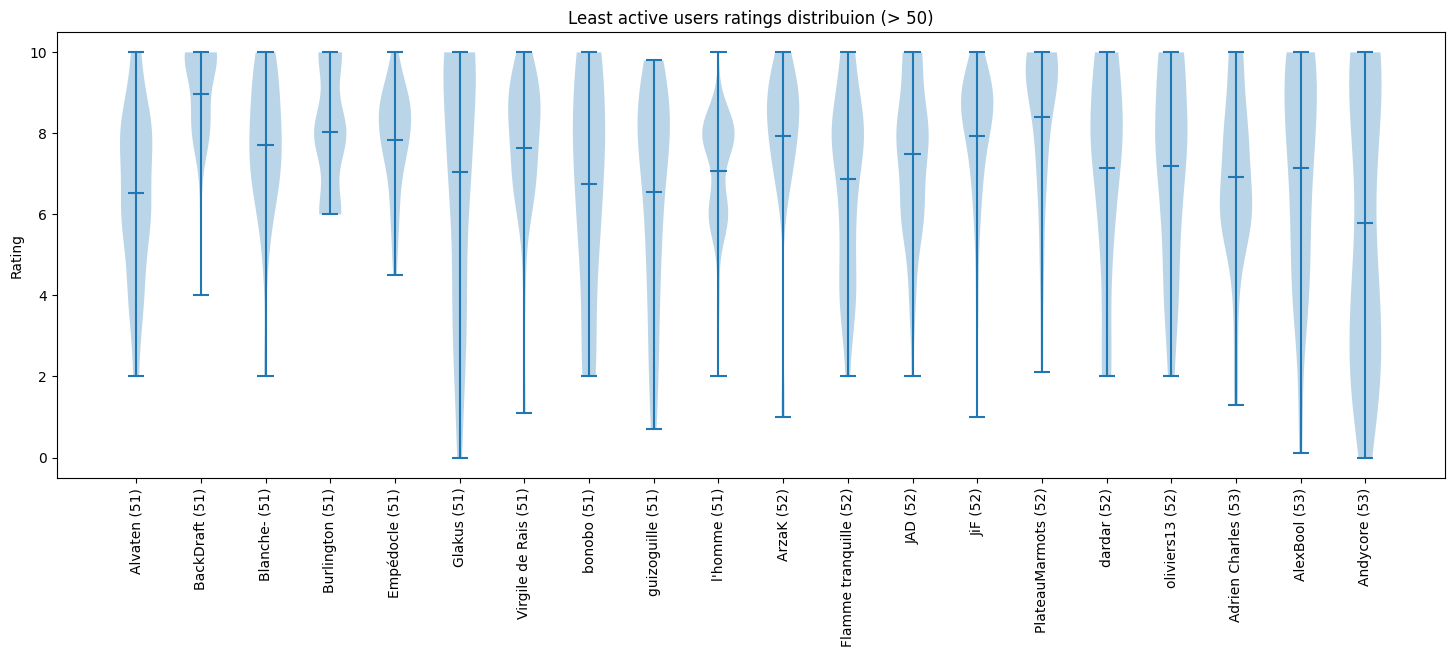

In [22]:
# Least active users (number of reviews based). Number of reviews > min_nb_rev
min_nb_rev = 50
bottom_users = users_ratings[users_ratings["count"] > min_nb_rev].nsmallest(n=20, columns="count")
bottom_users_merged = bottom_users.merge(avis_clean[["Username", "Rating"]], on="Username")
violinplot_data = bottom_users_merged[["Username", "Rating"]].groupby("Username")["Rating"].apply(np.array)

fig.set_figwidth(15)
fig.clear()
violin_plot(violinplot_data, ax=fig.add_subplot(111),
            data_labels=np.vectorize(lambda user, count: f"{user} ({count})")(bottom_users["Username"], bottom_users["count"]),
            y_label="Rating", title=f"Least active users ratings distribuion (> {min_nb_rev})", rotation=90)
fig

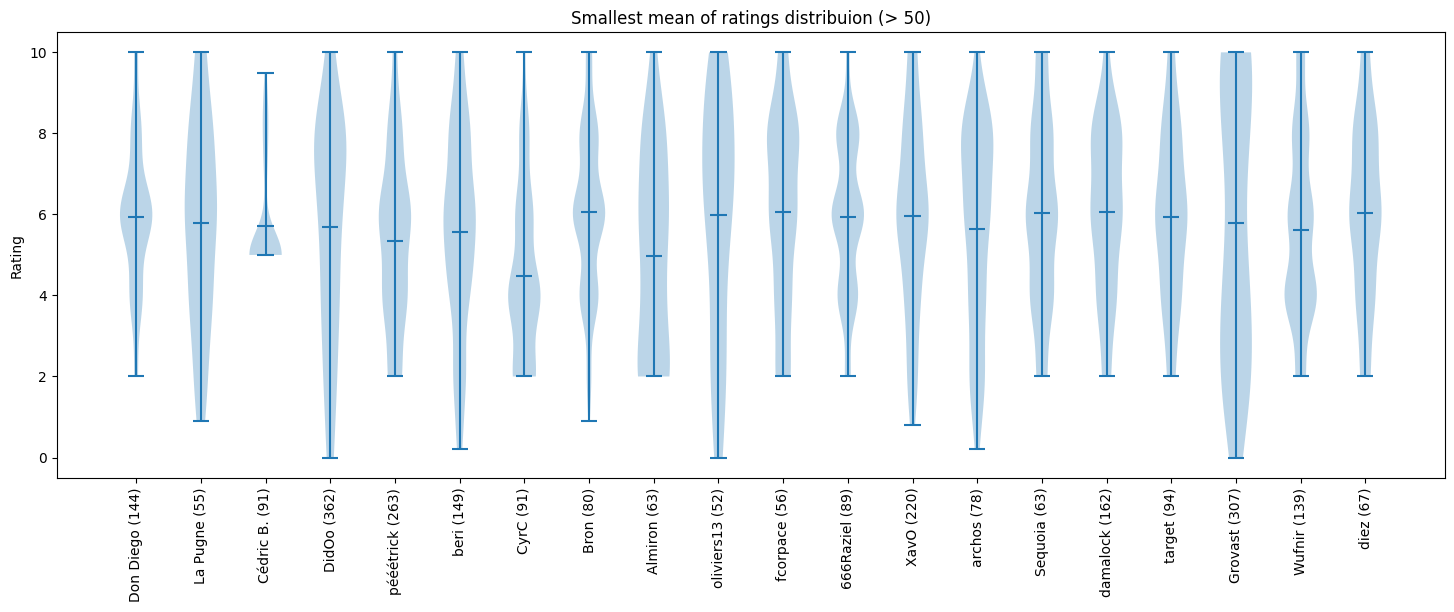

In [23]:
# Least active users (number of reviews based). Number of reviews > min_nb_rev
bottom_users = users_ratings[users_ratings["count"] > min_nb_rev].nsmallest(n=20, columns="mean")
bottom_users_merged = bottom_users.merge(avis_clean[["Username", "Rating"]], on="Username")
violinplot_data = bottom_users_merged[["Username", "Rating"]].groupby("Username")["Rating"].apply(np.array)

fig.set_figwidth(15)
fig.clear()
violin_plot(violinplot_data, ax=fig.add_subplot(111),
            data_labels=np.vectorize(lambda user, count: f"{user} ({count})")(bottom_users["Username"], bottom_users["count"]),
            y_label="Rating", title=f"Smallest mean of ratings distribuion (> {min_nb_rev})", rotation=90)
fig

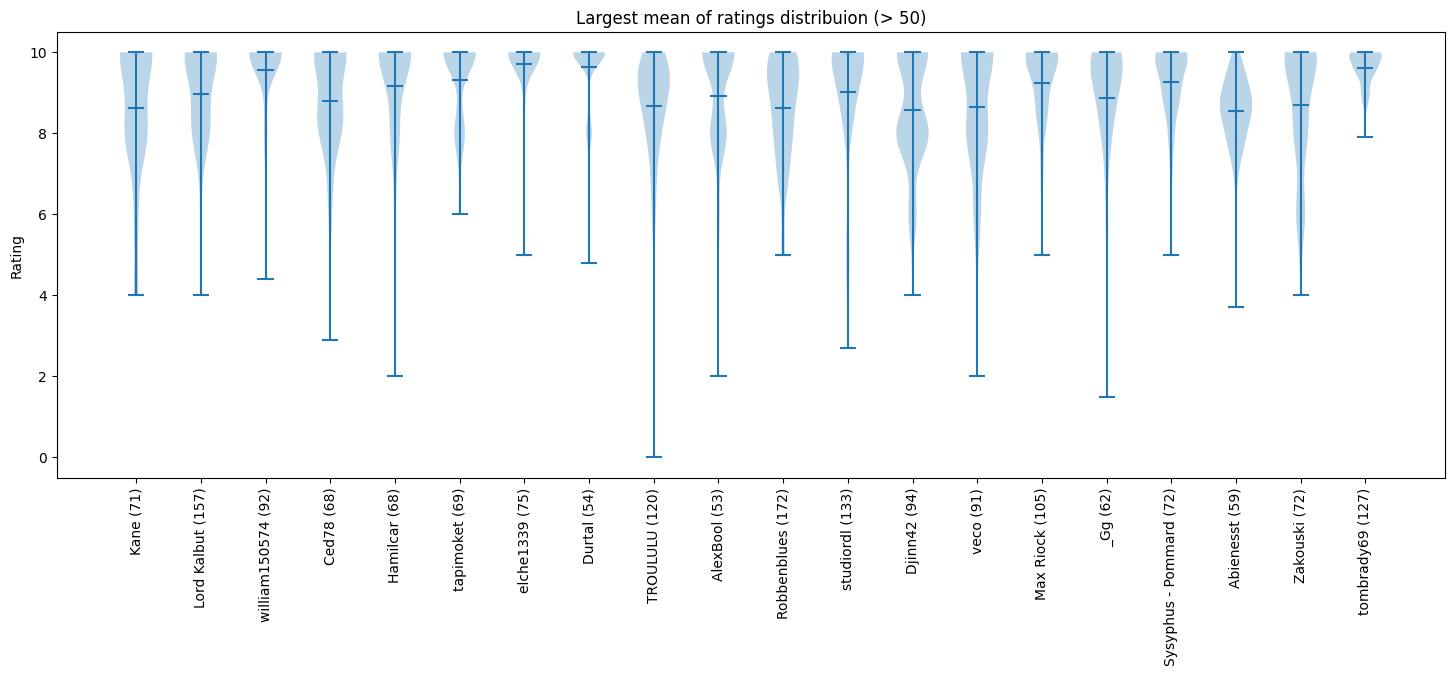

In [24]:
# Least active users (number of reviews based). Number of reviews > min_nb_rev
top_users = users_ratings[users_ratings["count"] > min_nb_rev].nlargest(n=20, columns="mean")
top_users_merged = top_users.merge(avis_clean[["Username", "Rating"]], on="Username")
violinplot_data = top_users_merged[["Username", "Rating"]].groupby("Username")["Rating"].apply(np.array)

fig.set_figwidth(15)
fig.clear()
violin_plot(violinplot_data, ax=fig.add_subplot(111),
            data_labels=np.vectorize(lambda user, count: f"{user} ({count})")(top_users["Username"], top_users["count"]),
            y_label="Rating", title=f"Largest mean of ratings distribuion (> {min_nb_rev})", rotation=90)
fig

In [80]:
categories = jeux_clean.loc[~jeux_clean["Type"].isna(), ["Type", "Game id"]]
categories["Type"] = categories["Type"].str.split('|')
categories_exp = categories.explode("Type")

avis_rating = avis_clean[["Game id", "Rating"]]
jeux_rating = categories_exp.merge(avis_rating, on="Game id")

types = np.unique(jeux_rating["Type"])

In [85]:
categories_largest = jeux_rating[["Type", "Rating"]].groupby("Type").count().reset_index().nlargest(30, "Rating")
categories_merged = categories_largest[["Type"]].merge(jeux_rating[["Type", "Rating"]])
data_larg = categories_merged.groupby("Type")["Rating"].apply(np.array)


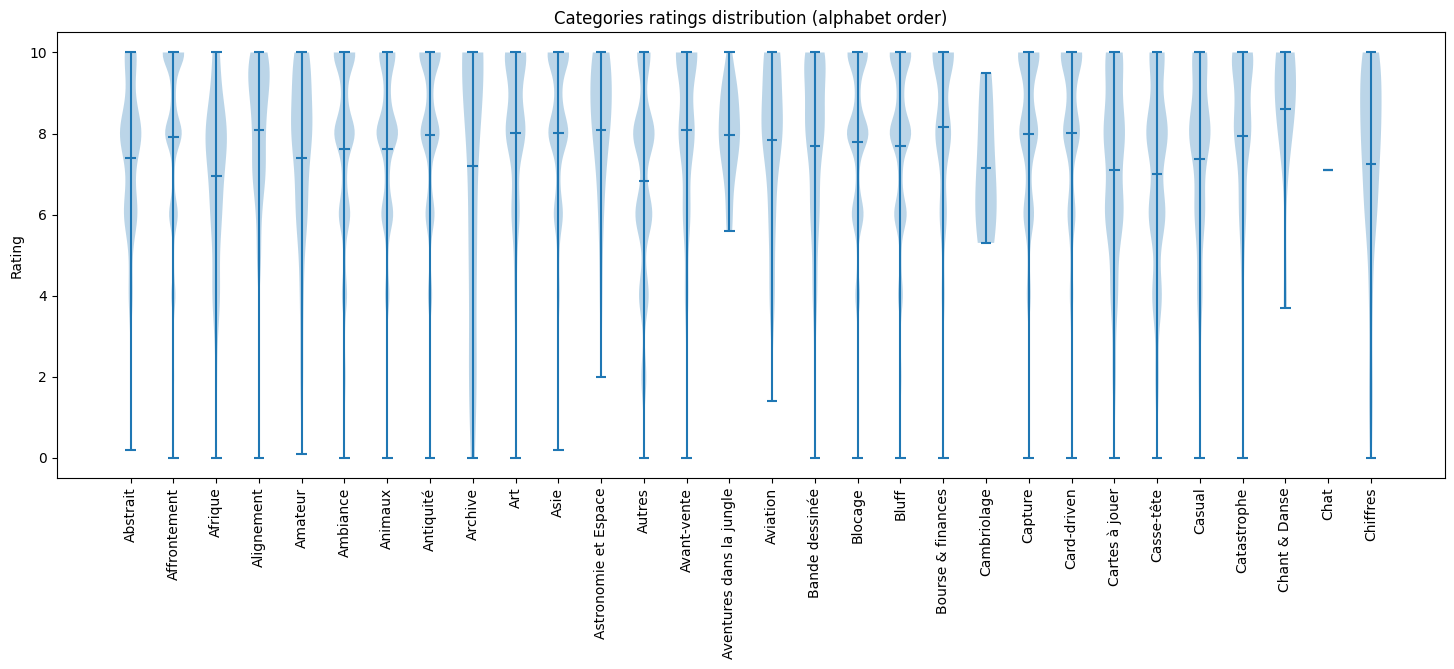

In [86]:
data_alph = jeux_rating[["Type", "Rating"]].groupby("Type")["Rating"].apply(np.array)[:30]

fig.clear()
violin_plot(data_alph, fig.add_subplot(111), data_alph.index, "Rating", "Categories ratings distribution (alphabet order)")
fig

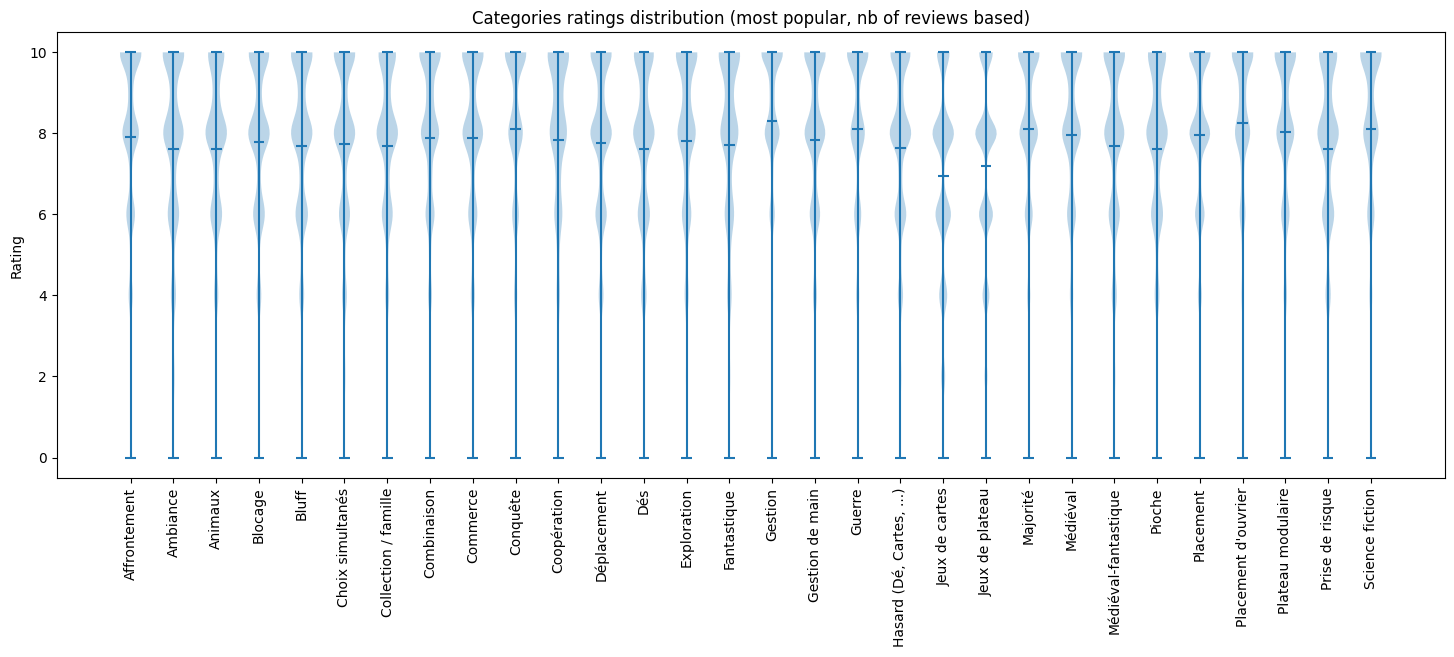

In [87]:

fig.clear()
violin_plot(data_larg, fig.add_subplot(111), data_larg.index, "Rating", "Categories ratings distribution (most popular, nb of reviews based)")
fig